## Linear regression with Pytorch
- The aim here is to start with a simple linear regression on some random data using Pytorch

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchinfo import summary

In [25]:
x = np.linspace(-1, 1, 100)
y = 3*x**2 - 2*x + 1 + 2*np.random.normal(0, 0.1, x.shape)

### The PyTorch model (classes and inheritance)
- In PyTorch, when we want to create a specific NN we create a class. This class tends to be a subclass of the generic class `nn.Module`, which why we write `class ourModel(nn.Module):`. In doing so we are inheriting from the base class `nn.Module`. This will allow us to call other methods in `nn.Module` which are not specified in our class.
- As always in Python, the class must contain an `__init__` method which is called when an instance of the class is created. We will then always start with the line `super(ourModel, self).__init__()`. This is calling the init method in the parent class. We then specify what components we will need in our model. Hence, we set up the attributes we want, eg: in the case below we include a linear layer which will be used afterwards in the forward method. 

In [37]:
class SimpleReg(nn.Module):
    def __init__(self):
        super(SimpleReg, self).__init__()
        self.fc = nn.Linear(1, 1)

    def forward(self, x):
        x = self.fc(x)
        return x

    def reset_weights(self):
        # Reset the weights of the linear layer
        self.fc.reset_parameters()

model = SimpleReg()

In [40]:
summary(model)

Layer (type:depth-idx)                   Param #
SimpleReg                                --
├─Linear: 1-1                            2
Total params: 2
Trainable params: 2
Non-trainable params: 0

In [26]:
(X_train,  
 X_test,
 Y_train, 
 Y_test) = train_test_split(x,
                            y,
                            test_size=0.2,
                            random_state=1)

# Convert numpy arrays to PyTorch tensors
# the .view is needed because PyTorch expects a 2D tensor
# with the first dimension being the number of samples
# and the second dimension being the number of features
X_train = torch.tensor(X_train, dtype=torch.float32).view(-1, 1)
Y_train = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32).view(-1, 1)
Y_test = torch.tensor(Y_test, dtype=torch.float32).view(-1, 1)


### Training
Let's briefly explain some lines in the code:
- During a forward pass, all operations performed on the input tensors are stored. These operations are stored on nodes in a *computational graph*. 
- When `loss.backward()` is called, PyTorch computes the gradients of the loss with respect to each parameter in the model by traversing this computational graph in reverse (backpropagation). Each parameter in `model.parameters()` will have a `.grad` attribute in which the gradient is stored.
- The `optimizer.step()` updates the model parameters using the computed gradients.
- Also, `loss = criterion(y_pred, Y_train)` is a tensor with a single scalar value. The method `.item()` extracts that scalar and converts it into a Python float.

In [39]:
# Loss function and optimiser
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
model.reset_weights()

# Training loop
for epoch in range(10000):
    optimizer.zero_grad() # sets greadients to 0
    y_pred = model(X_train)
    loss = criterion(y_pred, Y_train)
    loss_test = criterion(model(X_test), Y_test)
    loss.backward() # backpropagation
    optimizer.step()
    if epoch % 1000 == 0:
        print(f'Epoch {epoch} training loss: {loss.item()}, testing loss: {loss_test.item()}')

Epoch 0 training loss: 2.593313455581665, testing loss: 1.0860782861709595
Epoch 1000 training loss: 0.9122284650802612, testing loss: 0.5664304494857788
Epoch 2000 training loss: 0.9122282266616821, testing loss: 0.5665931105613708
Epoch 3000 training loss: 0.9122282266616821, testing loss: 0.5665931105613708
Epoch 4000 training loss: 0.9122282266616821, testing loss: 0.5665931105613708
Epoch 5000 training loss: 0.9122282266616821, testing loss: 0.5665931105613708
Epoch 6000 training loss: 0.9122282266616821, testing loss: 0.5665931105613708
Epoch 7000 training loss: 0.9122282266616821, testing loss: 0.5665931105613708
Epoch 8000 training loss: 0.9122282266616821, testing loss: 0.5665931105613708
Epoch 9000 training loss: 0.9122282266616821, testing loss: 0.5665931105613708


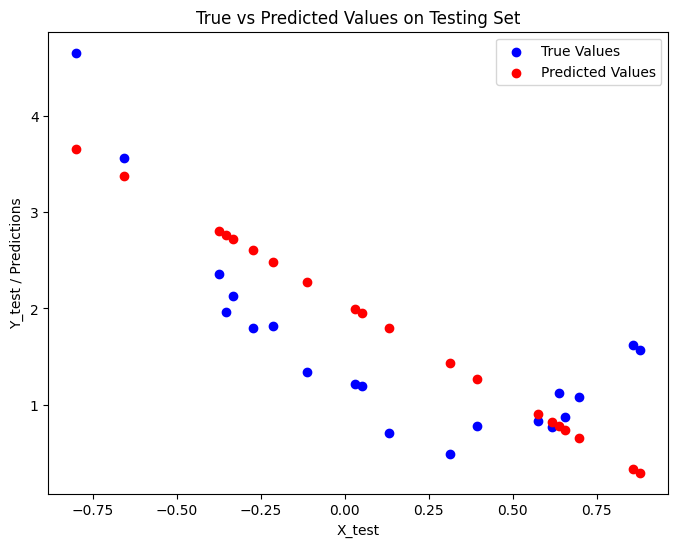

In [41]:
# Generate predictions on the testing set
y_pred_test = model(X_test).detach().numpy()

# Plot true vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(X_test.numpy(), Y_test.numpy(), color='blue', label='True Values')
plt.scatter(X_test.numpy(), y_pred_test, color='red', label='Predicted Values')
plt.xlabel('X_test')
plt.ylabel('Y_test / Predictions')
plt.title('True vs Predicted Values on Testing Set')
plt.legend()
plt.show()

## Polynomial regression
- How can we extend the model to include polynomial regression?

In [29]:
class PolynomialReg(nn.Module):
    def __init__(self, degree=2):
        super(PolynomialReg, self).__init__()
        self.degree = degree
        self.fc = nn.Linear(degree, 1)  # Adjust input features to match the degree

    def forward(self, x):
        # Create polynomial features
        poly_features = torch.cat([x**i for i in range(1, self.degree + 1)], dim=1)
        return self.fc(poly_features)

    def reset_weights(self):
        # Reset the weights of the linear layer
        self.fc.reset_parameters()

In [47]:
poly_model = PolynomialReg(degree=2)
# Loss function and optimiser
criterion = nn.MSELoss()
optimizer = optim.SGD(poly_model.parameters(), lr=0.01)
poly_model.reset_weights()

# Training loop
for epoch in range(100):
    optimizer.zero_grad() # sets greadients to 0
    y_pred = poly_model(X_train)
    loss = criterion(y_pred, Y_train)
    loss_test = criterion(poly_model(X_test), Y_test)
    loss.backward() # backpropagation
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch} training loss: {loss.item()}, testing loss: {loss_test.item()}')

Epoch 0 training loss: 6.8892083168029785, testing loss: 3.397855758666992
Epoch 10 training loss: 4.877384185791016, testing loss: 2.1940970420837402
Epoch 20 training loss: 3.5563228130340576, testing loss: 1.4696435928344727
Epoch 30 training loss: 2.677004337310791, testing loss: 1.0342592000961304
Epoch 40 training loss: 2.0817015171051025, testing loss: 0.7718877196311951
Epoch 50 training loss: 1.670310616493225, testing loss: 0.6121729612350464
Epoch 60 training loss: 1.379123330116272, testing loss: 0.5127907395362854
Epoch 70 training loss: 1.1674467325210571, testing loss: 0.4485175609588623
Epoch 80 training loss: 1.0091570615768433, testing loss: 0.4044937193393707
Epoch 90 training loss: 0.8873758316040039, testing loss: 0.3720887303352356


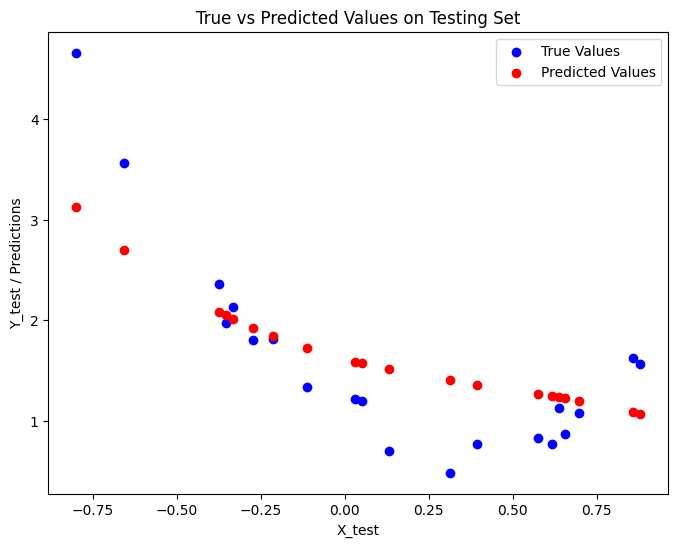

In [46]:
y_pred_test = poly_model(X_test).detach().numpy()

# Plot true vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(X_test.numpy(), Y_test.numpy(), color='blue', label='True Values')
plt.scatter(X_test.numpy(), y_pred_test, color='red', label='Predicted Values')
plt.xlabel('X_test')
plt.ylabel('Y_test / Predictions')
plt.title('True vs Predicted Values on Testing Set')
plt.legend()
plt.show()

### Convergence of stochastic gradient descent in regression models
- Notice that we are trying to minimise MSE, so the global optimiser will be given by the OLS estimator. Here we are fitting a polynomial regression (so it's the same model), but we are optimising through gradient descent. Can we say something about the convergence?
- Let our model be $Y = X\beta + \varepsilon$. The OLS estimator minimises the squared loss: 
$$ L(\beta) = \frac{1}{2n}||X\beta - y ||^2,$$
which has a closed form solution under reasonable conditions:
$$ \hat{\beta}_{OLS} = (X^TX)^{-1}X^Ty.$$
- Now, gradient descent optimises applying the formula
$$\beta^{(t+1)} = \beta^{(t)} - \eta \nabla L(\beta^{(t)},$$
where the gradient of the loss function is given by
$$ \nabla L(\beta) = \frac{1}{n}X^T(X\beta - y).$$ 
- Therefore, we can write the error at time $t+1$ as
$$\beta^{(t+1)} - \beta_{OLS} = (I-\eta H)(\beta^{(t)} - \beta_{OLS}),$$
where $H=\frac{1}{n}X^TX$ is the Hessian matrix. Hence, for an $\eta$ small enough (related to the eigenvalues of the Hessian), we will get convergence. 